# CausalRCA

The original implementation is here. <https://github.com/AXinx/CausalRCA_code/>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

import logging
logger = logging.getLogger()
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=False,
) 

In [33]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "carts")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1].iloc[0:180,:],
    data_df_by_metric_type["services"][-1].iloc[0:180, :],
], axis=1)
dataset.shape

(180, 76)

In [32]:
MANUALLY_SELECTED_METRICS: set[str] = {
    "latency",
    "cpu_usage_seconds_total",
    "memory_working_set_bytes",
    "fs_reads_total",
    "fs_writes_total",
    "network_receive_bytes_total",
    "network_transmit_bytes_total",
}

container_names = ['front-end', 'user', 'catalogue', 'orders', 'carts', 'payment', 'shipping']

def filter_manually_selected_metrics(df: pd.DataFrame) -> pd.DataFrame:
    # Filter only container metrics
    return df.loc[
        :,
        [
            (not metric_name.startswith("m-") and not metric_name.startswith("n-")) and any([metric_name.endswith(base_name) for base_name in MANUALLY_SELECTED_METRICS])
            for metric_name in df.columns.tolist()
        ],
    ]

def filter_by_container_names(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[
        :,
        [
            metric_name.split("_")[0].removeprefix("c-") in container_names
            for metric_name in df.columns.tolist()
        ],
    ]

dataset = filter_by_container_names(filter_manually_selected_metrics(record.data_df).iloc[0:180, :])
dataset.shape


(180, 42)

In [34]:
from scipy.stats import zscore
dataset = dataset.apply(lambda x: zscore(x, nan_policy="omit"))
dataset

,c-carts_network_transmit_packets_total,c-carts_cpu_cfs_periods_total,c-carts_threads,c-carts_memory_mapped_file,c-carts-db_memory_usage_bytes,c-carts_cpu_system_seconds_total,c-carts-db_cpu_cfs_periods_total,c-carts-db_fs_reads_bytes_total,c-carts-db_threads,c-carts-db_cpu_cfs_throttled_seconds_total,...,s-payment_latency,s-shipping_throughput,s-carts_throughput,s-user_throughput,s-front-end_latency,s-orders_throughput,s-user_latency,s-payment_throughput,s-shipping_latency,s-orders_latency
0,0.562096,0.473706,-0.269612,-0.333333,0.809719,0.086241,0.430242,-0.168767,-0.074744,-0.462989,...,-0.166220,0.217793,0.746314,0.672058,-0.294557,0.825122,-1.104055,0.229658,0.042357,-0.350375
1,0.448423,0.469485,-0.669038,-0.333333,0.809719,0.133771,-2.296684,-0.168767,-0.074744,-0.582728,...,-1.234775,0.262161,0.842642,0.894638,-1.085283,0.627071,-1.104055,0.952721,-0.502238,-0.501049
2,0.512214,-2.069359,-0.669038,-0.333333,0.816531,-1.729415,0.439295,-0.168767,-0.074744,-0.492924,...,-1.234775,1.172610,0.967885,1.071556,-1.002048,1.081178,-0.299480,0.836092,0.042357,-0.328851
3,0.495256,0.486037,-0.669038,-0.333333,0.821754,0.618580,0.428908,-0.168767,-0.074744,-0.507891,...,-1.234775,1.172610,1.189457,1.157152,-1.293368,0.713591,-0.299480,1.199990,0.042357,-0.587148
4,0.556717,0.477705,-0.269612,-0.333333,0.821754,0.761171,-2.565127,-0.168767,-0.074744,-0.477956,...,-0.166220,0.883917,1.256869,1.277007,-1.043665,1.146092,-0.299480,1.199990,-0.502238,-0.565623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.686023,0.493480,3.125506,3.000000,-0.506133,2.576827,0.361058,-0.168767,-0.074744,5.344331,...,3.039446,-1.492184,-2.307609,-1.941734,1.952769,-1.860101,1.309668,-2.155871,0.042357,2.964439
176,-2.166548,0.486037,3.125506,3.000000,-0.355134,2.415224,0.324085,-0.168767,-0.074744,4.206815,...,4.108001,-2.691326,-2.577344,-2.432530,2.618643,-2.465641,1.309668,-2.519768,0.042357,2.985963
177,0.513590,0.478372,2.726080,3.000000,-0.257949,2.006464,0.302548,-0.168767,-0.074744,2.710083,...,1.970890,-2.802347,-2.644800,-2.563787,2.577026,-2.660286,0.505094,-2.560343,2.220738,3.674756
178,0.641639,-1.448368,3.125506,3.000000,-0.310175,-0.255977,0.291208,-0.168767,-0.074744,2.290998,...,1.970890,-2.624674,-2.240153,-2.255611,2.244089,-2.487247,0.505094,-2.034693,4.399118,3.481033


In [8]:
from diagnoser.causalrca import CausalRCA
from diagnoser.daggnn.config import Config

In [43]:
params = Config().to_prefixed_dict(prefix="causalrca")
# params["causalrca_epochs"] = 1000
conf = Config.from_prefixed_dict(prefix="causalrca", **params)
print(conf)
causalrca = CausalRCA(dataset, conf)
graph_adj, elapsed = causalrca.fit()

Config(epochs=1000, sample_to_batch_size_factor=5, lr=0.001, x_dims=1, z_dims=1, optimizer='Adam', graph_threshold=0.0, tau_A=0.0, lambda_A=0.0, c_A=1, c_A_ul=1e+20, use_A_connect_loss=1, use_A_positiver_loss=1, cuda=False, seed=42, encoder_hidden=64, decoder_hidden=64, temp=0.5, k_max_iter=3, encoder='mlp', decoder='mlp', encoder_dropout=0.0, decoder_dropout=0.0, h_tol=1e-08, lr_decay=200, sche_gamma=1.0, prior=False, factor=True, eta=10, gamma=0.25)
Step: 1/3, Best Epoch: 887/1000, ELBO Loss: 0.16406351130483868, NLL Loss: 0.0011657940455872776, MSE Loss: 3.067879067334941e-05
Step: 2/3, Best Epoch: 1000/1000, ELBO Loss: 0.11754460763773836, NLL Loss: 0.0007376248172419824, MSE Loss: 1.94111794011048e-05
Step: 2/3, Best Epoch: 1000/1000, ELBO Loss: 0.10534646011133929, NLL Loss: 0.0004642931711277473, MSE Loss: 1.2218241345467034e-05
Done!


In [45]:
ranks = causalrca.rank(graph_adj)
ranks

{52: ('c-user_memory_rss', 0.013716138460996116),
 47: ('c-payment_cpu_user_seconds_total', 0.013650508195977334),
 71: ('s-orders_throughput', 0.01364192556805666),
 68: ('s-carts_throughput', 0.013638687691799795),
 69: ('s-user_throughput', 0.013622815064746715),
 67: ('s-shipping_throughput', 0.013620918899414927),
 63: ('s-catalogue_throughput', 0.013612876333784038),
 73: ('s-payment_throughput', 0.01361203102234207),
 23: ('c-front-end_cpu_cfs_throttled_periods_total', 0.013483268644235845),
 48: ('c-payment_memory_usage_bytes', 0.013482913840488147),
 37: ('c-shipping_network_receive_bytes_total', 0.013474184250320397),
 41: ('c-orders-db_memory_cache', 0.013444215623930677),
 13: ('c-catalogue_cpu_usage_seconds_total', 0.013427057810396052),
 46: ('c-orders-db_network_receive_bytes_total', 0.013348565606590194),
 33: ('c-orders-db_network_transmit_bytes_total', 0.013340756635093431),
 17: ('c-catalogue-db_cpu_usage_seconds_total', 0.013337967000582304),
 40: ('c-orders-db_cpu_

[]

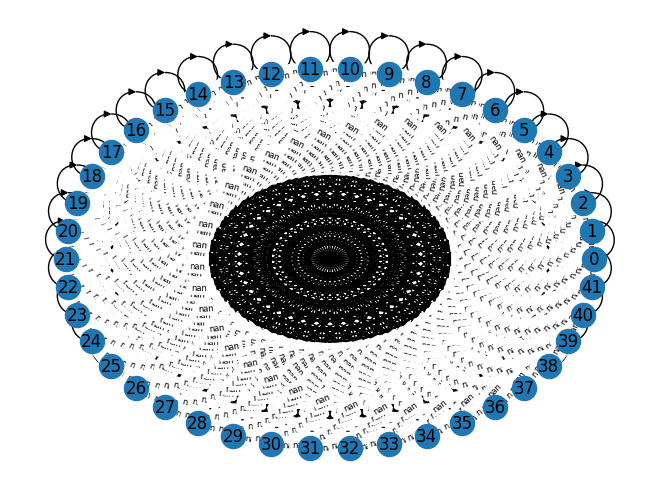

In [11]:
import networkx as nx

_graph_adj = graph_adj.copy()
_graph_adj[np.abs(_graph_adj) < 0.5] = 0
org_G = nx.DiGraph(_graph_adj)
pos=nx.circular_layout(org_G)
nx.draw(org_G, pos=pos, with_labels=True)
edge_labels = {k: round(w, 2) for k, w in nx.get_edge_attributes(org_G, "weight").items()}
nx.draw_networkx_edge_labels(org_G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.25)
plt.plot()

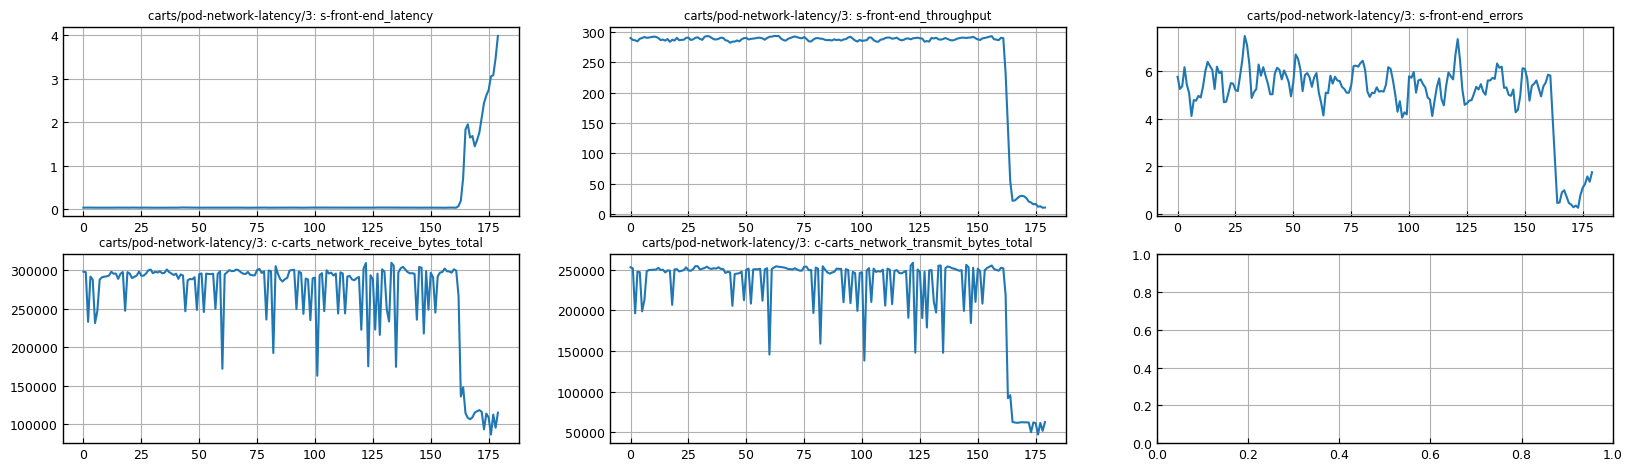

In [12]:
from notebooklib import plot

plot.plot_sli_and_causal_metrics(dataset, record)
# plot.plot_dataset_dataframe(dataset, record)